In [226]:
# This Python file uses the following encoding: utf-8
import os, sys
%matplotlib inline
import numpy as np
import pandas as pd
from English_to_IPA import conversion
import re
import matplotlib.pyplot as plt
import json
from matplotlib.font_manager import FontProperties
from num2words import num2words
from six.moves import cPickle as pickle
from copy import deepcopy
import math
from math import factorial
import time
import nltk
from nltk.tokenize import RegexpTokenizer

In [227]:
categories = ['Oral Cavity',
              'Mouth Openness',
              'Obstruent',
              'Tongue Positioning',
              'Resonance',
              'Vowel','Round','Tense']
eSPEDict = dict()
with open('eSPEPhonologicalTableV2') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDict[line[0]] = np.array([eval(x) for x in line[1:]])

In [228]:
def split_text(text):
    text = re.sub('\n+', '\n', text)
    splitted_text = re.sub(' +', ' ', clean_text(text)).split(' ')
    return [ word.lower() for word in splitted_text if word != '']

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~«»“…‘”'
    for p in punct_str:
        text = text.replace(p,' ')
    return text  
    
def is_number(word):
    try:
        int(word)
        return True
    except ValueError:
        pass
    return False

def change_number_to_string(number):
    return num2words(int(number))

def is_empty(sequence):
    if len(sequence) == 0:
        return True
    return False

# Load Data

In [229]:
valid_dev = pd.read_csv('data/common_voice/cv-valid-dev.csv',index_col=0)
valid_train = pd.read_csv('data/common_voice/cv-valid-train.csv',dtype={'ambiguous': str,'emotion':object},index_col=0)
valid_test = pd.read_csv('data/common_voice/cv-valid-test.csv',index_col=0)


In [230]:
print('Development Dataset size:',len(valid_dev))

print('Training Dataset size:',len(valid_train))

print('Test Dataset size:', len(valid_test))
#valid_dev.head()
#valid_train.head()
#valid_test.head()

('Development Dataset size:', 4076)
('Training Dataset size:', 195775)
('Test Dataset size:', 3995)


# Energy Score

In [231]:
def get_score(text):
    word_count = 0
    score = np.zeros((8,), dtype=np.int)
    words = split_text(text)
    print(text)
    for word in words:
        print(word)
        if word == '':
            continue
        if is_number(word):
            #print("Found number: "+ word)
            word = change_number_to_string(word)
        cmu, ipa = conversion.convert(word)
        punct = '[ˌˈ ]'
        for p in punct:
            ipa = ipa.replace(p , '')
        if '*' in ipa:        
            #print('No IPA Found for: '+ word)
            continue
        word_count += 1
        i = 0
        while i < len(ipa):
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDict[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDict[sym]
                    i += 1
    score = np.append(score, word_count)
    return score

def len_words(text):
    return len(text.split(' '))

import requests
import json

def get_emotion(text):
    payload = {"lang":"und","text":text}
    url = 'http://140.114.77.14:8080/webresources/jammin/emotion'
    try:
        r = requests.post(url, data=json.dumps(payload))
    except Exception:
        r = requests.post(url, data=json.dumps(payload))
    pass
    r = r.json()
    return r['ambiguous'], list(item['name'] for item in r['groups'])

In [232]:
#valid_dev['energy_score'] = valid_dev['text'].apply(get_score)
#valid_train['energy_score'] = valid_train['text'].apply(get_score)
#valid_test['energy_score'] = valid_test['text'].apply(get_score)

In [233]:
#valid_train['text_len'] = valid_train['text'].apply(len_words)
#valid_dev['text_len'] = valid_dev['text'].apply(len_words)
#valid_test['text_len'] = valid_test['text'].apply(len_words)

# Get Emotion for each value - Carlos Argueta EmoClassifier

In [234]:
# for i, item in valid_dev.iterrows():
#     ambiguous, emotion = get_emotion(item['text'])
#     valid_dev.loc[i,'ambiguous'] =  ambiguous
#     valid_dev.loc[i,'emotion'] = str(emotion)
#     if i % 100 == 0:
#         #valid_dev.to_csv('common-voice/cv-valid-dev.csv')
#         print('Saved at index',i)
# #valid_dev.to_csv('common-voice/cv-valid-dev.csv')
# valid_dev.head()
    

In [235]:
# # valid_train['ambiguous'], valid_train['emotion'] = valid_train['text'].apply(get_emotion)
# for i, item in valid_train[valid_train.emotion != valid_train.emotion].iterrows():
#     ambiguous, emotion = get_emotion(item['text'])
#     valid_train.loc[i,'ambiguous'] =  ambiguous
#     valid_train.loc[i,'emotion'] = str(emotion)
#     if i % 100 == 0:
#         print('at index',i)
#         if i % 500 == 0:   
#             valid_train.to_csv('common-voice/cv-valid-train.csv')
#             print('Saved at index',i)
# valid_train.to_csv('common-voice/cv-valid-train.csv')
# valid_train.head()

In [236]:
# for i, item in valid_test.iterrows():
#     ambiguous, emotion = get_emotion(item['text'])
#     valid_test.loc[i,'ambiguous'] =  ambiguous
#     valid_test.loc[i,'emotion'] = str(emotion)
#     if i % 100 == 0:
#         print('at index',i )
#         if i % 500 == 0:   
#             valid_test.to_csv('data/common_voice/cv-valid-test.csv')
#             print('Saved at index',i)
# valid_test.to_csv('data/common_voice/cv-valid-test.csv')
# valid_test.head()

# Deep Emotion - Toby Liu EmotionClassifier

In [237]:
def get_deep_emotion(text):
    url = 'http://192.168.2.101:7878/api/get_emo'
    data = dict(input_tweets = text)
    resp = requests.post(url=url, data=data)
    r = json.loads(resp.text)
    return r

In [238]:
# multiplier = 100
# iterations = len(valid_dev)/multiplier
# df = []
# for i in range(iterations):
#     init_i = i*multiplier
#     last_i
#     if(i == iterations-1):
#         last_i = len(valid_dev)
#     else:    
#         last_i = (i+1)*multiplier
#     values = valid_dev['text'][init_i:last_i]
#     text = json.dumps(list(values))
#     result = get_deep_emotion(text)
#     temp_df = pd.DataFrame(data=result)
#     df.append(temp_df)
#     print('Added from',init_i,'to',last_i)
    
# concated_df = pd.concat(df)
# concated_df.to_csv('data/common_voice/deep-emo-dev.csv')

In [239]:
# multiplier = 500
# iterations = len(valid_train)/multiplier

# df = []
# for i in range(iterations):
#     init_i = i*multiplier
#     last_i = (i+1)*multiplier
#     if(i == iterations-1):
#         last_i = len(valid_train)
#     values = valid_train['text'][init_i:last_i]
#     text = json.dumps(list(values))
#     result = get_deep_emotion(text)
#     temp_df = pd.DataFrame(data=result)
#     df.append(temp_df)
#     print('Added from',init_i,'to',last_i)
    
    
# concated_df = pd.concat(df)
# concated_df.to_csv('data/common_voice/deep-emo-train.csv')

In [240]:
# multiplier = 100
# iterations = len(valid_test)/multiplier

# df = []
# for i in range(iterations):
#     init_i = i*multiplier
#     last_i = (i+1)*multiplier
#     if(i == iterations-1):
#         last_i = len(valid_test)
#     values = valid_test['text'][init_i:last_i]
#     text = json.dumps(list(values))
#     result = get_deep_emotion(text)
#     temp_df = pd.DataFrame(data=result)
#     df.append(temp_df)
#     print('Added from',init_i,'to',last_i)

# concated_df = pd.concat(df)
# concated_df.to_csv('data/common_voice/deep-emo-test.csv')

In [241]:
deep_emo_test = pd.read_csv('data/common_voice/deep-emo-test.csv',index_col=0)
deep_emo_train = pd.read_csv('data/common_voice/deep-emo-train.csv',index_col=0)
deep_emo_dev = pd.read_csv('data/common_voice/deep-emo-dev.csv',index_col=0)

# Get Label Data

In [242]:
def wildcarder(sent,num):
    result = []
    tokens = sent.split()
    for i in range(num+1,len(tokens)-1):
        new_tokens = deepcopy(tokens)
        new_tokens[i] = '.+'
        result.append(' '.join(new_tokens))
    return result

def wildcarder_rec(sent,num):
    result = []
    if num > len(sent)-2:
        return [sent]
    else:
        wild_res = wildcarder(sent,num)
        for i in range(0,len(wild_res)):
            result.append(wild_res[i])
            res = wildcarder_rec(wild_res[i],num+1+i)
            result.extend(res)
        return result
    

def pattern_generator(sent):
    #special top level cases
    result = [sent]    #whole sentence
    tokens = sent.split()
    if len(tokens)>2:
        sc1 = pattern_generator(' '.join(tokens[1:]))   #whole sentence except first word
        sc2 = pattern_generator(' '.join(tokens[:-1]))   #whole sentence except last word
        result.extend(sc1)
        result.extend(sc2)
    elif len(tokens) == 2: #reached a leaf
        result.append(tokens[0])    
        result.append(tokens[1])  
    result.extend(wildcarder_rec(sent,0))
    return list(set(result))

def sentence_splitter(sentences,n):
    result = []
    for sent in sentences:
        new_sents = [x.lower().strip() for x in sent.split(',')]
        for new_sent in new_sents:
            tokens = new_sent.split()
            for i in range(0, len(tokens), n):
                x = ' '.join(tokens[i:i+n])
                result.append(x)
    return result

def check_patterns(data,text):
    patterns_dic = {}
    #patterns = pattern_generator(text)
    patterns = text
    index = 0
    for d in data:
        stext = nltk.sent_tokenize(d)
        stext = sentence_splitter(stext,5)
        for s in stext:
            d_patterns = pattern_generator(s)
            for dp in d_patterns:
                if dp in patterns:
                    print(d)
                    if dp in patterns_dic:
                        patterns_dic[dp].append(index)
                    else:
                        patterns_dic[dp] = [index]
                        
        index = index + 1 
     
    print(index)
    return patterns_dic

## Joy Tags 

In [279]:
joy_tags = ['happy','happier','happiest','joy','joyful','awesome']
# 17 Labels

dev_patterns = check_patterns(list(deep_emo_dev['text']),joy_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),joy_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),joy_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]


all the joy he had seen that morning had suddenly disappeared
they were relieved and happy
if you can concentrate always on the present you'll be a happy man
we miss you and miss having a friend like you and i am so happy that you two got to catch up
they seemed to laugh at him and he laughed back his heart bursting with joy
if you can concentrate always on the present you'll be a happy man
the boy was suddenly happy to be there at the warehouse
but instead of being saddened he was happy
all who went there were happy at having done so
when i had my sheep i was happy and i made those around me happy
when i had my sheep i was happy and i made those around me happy
they were relieved and happy
when i had my sheep i was happy and i made those around me happy
when i had my sheep i was happy and i made those around me happy
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
we miss you and miss having a friend like you and i am so happy that you two

he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float

all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but inst

all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but inst

but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float

all the joy he had seen that morning had suddenly disappeared
he said to float away to happy land on the bubbles
he said to float away to happy land on the bubbles
but instead of being saddened he was happy
all the joy he had seen that morning had suddenly disappeared
when i had my sheep i was happy and i made those around me happy
when i had my sheep i was happy and i made those around me happy
all the joy he had seen that morning had suddenly disappeared
drink and enjoy yourself said the alchemist noticing that the boy was feeling happier
195775
3995


In [182]:
testtrain.groupby(['text']).head(1)
testdev.groupby(['text']).head(1)
testtest.groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,text
903,0.130442,0.170388,0.004867,0.083017,0.145721,0.176103,0.247738,0.041724,all the joy he had seen that morning had sudde...
1603,0.063335,0.067162,0.007874,0.015908,0.054683,0.157178,0.028912,0.604948,drink and enjoy yourself said the alchemist no...
213,0.044569,0.002226,0.005662,0.012310,0.837224,0.084405,0.006447,0.007158,he said to float away to happy land on the bub...
421,0.121675,0.000947,0.004803,0.007468,0.015610,0.666386,0.175663,0.007447,but instead of being saddened he was happy
1012,0.219188,0.001391,0.306097,0.180835,0.066918,0.212635,0.007236,0.005700,when i had my sheep i was happy and i made tho...


In [281]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
all the joy he had seen that morning had suddenly disappeared,198,198,198,198,198,198,198,198
all who went there were happy at having done so,2,2,2,2,2,2,2,2
but instead of being saddened he was happy,198,198,198,198,198,198,198,198
drink and enjoy yourself said the alchemist noticing that the boy was feeling happier,1,1,1,1,1,1,1,1
he said to float away to happy land on the bubbles,391,391,391,391,391,391,391,391
i wish you every possible happiness and joy,1,1,1,1,1,1,1,1
if you can concentrate always on the present you'll be a happy man,2,2,2,2,2,2,2,2
the boy was suddenly happy to be there at the warehouse,1,1,1,1,1,1,1,1
they seemed to laugh at him and he laughed back his heart bursting with joy,1,1,1,1,1,1,1,1


## Anger Tags

In [276]:
anger_tags = ['stop','abuse','abusive','agression','angry','anger','angrier','angriest','annoy','annoyed','annoying','annoys','asshole','bastard','bitch']
#17 Labels

dev_patterns = check_patterns(list(deep_emo_dev['text']),anger_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),anger_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),anger_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]

the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
stop treating me like a child
you can't stop for a thing now
how do you stop this thing
let's stop this another commander said
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
let's stop this another commander said
i couldnt stop staring at it
never stop dreaming the old king had said
he asked it please never to stop speaking to him
i couldnt stop staring at it
i'm getting out of here and you can't stop me
if someone isn't what others want them to be the others become angry
let's stop this another commander said
4076
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful a

he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop s

i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i cou

i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if yo

i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i cou

i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you ca

he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop s

and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm getting out of here and you can't stop me
i couldnt stop staring at it
i couldnt stop staring at it
if you don't stop following me i'll call the police
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
he asked it please never to stop speaking to him
and stop threatening that boy
i'm 

In [192]:
testtrain.groupby([ 'text']).head(1)
testdev.groupby(['text']).head(1)

14                           i couldnt stop staring at it
609     if you don't stop following me i'll call the p...
776     the guy thought he was a lunatic at large and ...
794      he asked it please never to stop speaking to him
861                         and stop threatening that boy
977         i'm getting out of here and you can't stop me
1587                             what did you stop it for
Name: text, dtype: object

In [278]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
and stop threatening that boy,195,195,195,195,195,195,195,195
he asked it please never to stop speaking to him,196,196,196,196,196,196,196,196
how do you stop this thing,1,1,1,1,1,1,1,1
i couldnt stop staring at it,393,393,393,393,393,393,393,393
i'm getting out of here and you can't stop me,196,196,196,196,196,196,196,196
if someone isn't what others want them to be the others become angry,1,1,1,1,1,1,1,1
if you don't stop following me i'll call the police,195,195,195,195,195,195,195,195
let's stop this another commander said,3,3,3,3,3,3,3,3
never stop dreaming the old king had said,1,1,1,1,1,1,1,1


## Sadness Tags

In [273]:
sadness_tags = ['alone','abandon','sad','sadder','saddest','cry','cried','cries','crushed','depress','depressed','depression','disappoint','disappointed','gloom','gloomie','gloomies','gloomily','gloominess','gloomy','grief','grieved','heartbreak','heartbroke','heartbroken','helpless','homesick','hopeless','hurt','inadequate','inferior','inferiority','isolated','isolate','lame','lamely','lameness','lamer','lamest','lone','lonelier','loneliness','lonely','longing','melancholy','melancholic','miss','missed','misses','missing','mourn','overwhelm','pathetic','pathetically','pessimist','regret','reject','remorse','ruin','sadly','sadness','sob','sobbed','sobbing','sobs','solemn','sorrow','sorry','suffer','suffered','sufferer','suffering','suffers','tears','tragic','tragically','unhappy','unimportant','unsuccessful','useless','uselessly','uselessness','weep','wept','worthless','yearn']
#69 Labels

dev_patterns = check_patterns(list(deep_emo_dev['text']),sadness_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),sadness_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),sadness_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]

it had told him to dig where his tears fell
it made me very depressed
sadly my dream of becoming a squirrel whisperer may never happen
i got two giant bug bites on my right leg from last night and they hurt
now leave us alone said the boy to the young arab
he saw that fatima's eyes were filled with tears
he didn't want to cry with the other people there
sadly my dream of becoming a squirrel whisperer may never happen
i'm going to miss annie
now leave us alone said the boy to the young arab
i dont mind working from home most of the time but i do miss having coworkers
i got two giant bug bites on my right leg from last night and they hurt
she cried for an hour
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
without the dataset the article is useless
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
and better still to be alone with one's books
a missing parrot is called a polygon
his eyes filled with tears as he 

the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opp

i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a g

sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer

the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her 

sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the cit

the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he w

it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again belie

sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer

it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again belie

it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again belie

but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my drea

sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept 

if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disa

it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an un

if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disa

i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a g

it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him
but he had found a guide and didn't want to miss out on an opportunity
so the boy was disappointed he decided that he would never again believe in dreams
the boy was sad as he left her that day
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
sadly my dream of becoming a squirrel whisperer may never happen
the boy felt ill and terribly alone
it won't hurt you and we can make the city edition
i was disappointed at this inanimate bulk
the man wept with happiness
if he ever decided to leave them they would suffer
it had told him to dig where his tears fell
the guy thought he was a lunatic at large and made an un

In [173]:
testdev.groupby(['text']).head(1)
testtrain.groupby(['text']).head(1)

,text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
392,she cried for an hour,0.215383,2.675542e-02,0.013627,0.231841,0.031366,0.461701,0.008647,0.010680
2376,this can't be stressed enough i am innocent he...,0.137318,2.284958e-02,0.090101,0.202891,0.110434,0.107824,0.307446,0.021136
3096,their horses cried out and all their weapons w...,0.558382,3.411110e-03,0.017141,0.015900,0.034766,0.359539,0.008589,0.002272
1010,but now i'm sad and alone,0.072539,2.559469e-03,0.009820,0.065129,0.026358,0.810835,0.006534,0.006225
2569,the boy was sad as he left her that day,0.043915,3.650357e-04,0.014511,0.009795,0.045059,0.875717,0.006675,0.003963
418,the guy thought he was a lunatic at large and ...,0.171728,2.078085e-04,0.109675,0.439669,0.071505,0.195936,0.008450,0.002828
3603,if he ever decided to leave them they would su...,0.300258,8.510574e-03,0.027984,0.019110,0.076148,0.545163,0.014040,0.008786
317,i'm going to miss annie,0.095193,7.574339e-02,0.011548,0.090950,0.047935,0.481190,0.070724,0.126718
378,i dont mind working from home most of the time...,0.028643,7.729992e-06,0.000874,0.001685,0.003328,0.960292,0.004597,0.000573
989,we miss you and miss having a friend like you ...,0.003191,2.089763e-09,0.000279,0.000269,0.004593,0.991505,0.000149,0.000014


In [275]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
a missing parrot is called a polygon,1,1,1,1,1,1,1,1
all i want to do is be let alone,1,1,1,1,1,1,1,1
and better still to be alone with one's books,2,2,2,2,2,2,2,2
and i'm sorry to say that the congestion is increasing,1,1,1,1,1,1,1,1
but he had found a guide and didn't want to miss out on an opportunity,197,197,197,197,197,197,197,197
but men began to reject simple things and to write tracts interpretations and philosophical studies,3,3,3,3,3,3,3,3
but now i'm sad and alone,2,2,2,2,2,2,2,2
but the marketplace was empty and he was far from home so he wept,2,2,2,2,2,2,2,2
but you've got to leave me alone,1,1,1,1,1,1,1,1


## Fear Tags

In [270]:
fear_tags = ['fear','scared','scary','fearful','feared','fears','fright','frightened','afraid','angst','anxierty','anxious','concern','concerned','horror','panic','panicked','horrorific','trembling','worry','worried','scare','terror']
# 16 Labels

dev_patterns = check_patterns(list(deep_emo_dev['text']),fear_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),fear_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),fear_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]


i was scared but wasted no time in going out and crossing the bridge to the sand pits
i was scared but wasted no time in going out and crossing the bridge to the sand pits
they're not concerned with that right now
afraid it might rain
the camel driver though seemed not to be very concerned with the threat of war
the idea frightened him
the boy became fearful the omens told him that something was wrong
tell your heart that the fear of suffering is worse than the suffering itself
but he didn't need to worry about that right now
they were known as seers and they were held in fear by women and the elderly
he had found where his treasure was and was frightened at what might happen
it was my fear of failure that first kept me from attempting the master work
tell your heart that the fear of suffering is worse than the suffering itself
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
he wanted to say so to the alchemi

i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him

i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing be

so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afrai

i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him

i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd 

so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afrai

don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the

i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing be

so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afrai

i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing be

don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i wa

don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the

don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the bridge to the sand pits
i'm not afraid of failing
so now i fear nothing because it was those omens that brought you to me
don't let them see that you're afraid the alchemist said
don't give in to your fears said the alchemist in a strangely gentle voice
i'm afraid she'd feel ashamed to think she hadn't trusted you
not to worry said the alchemist
i'm afraid the joke's on us
the boy was shaking with fear but the alchemist helped him out of the tent
i'm afraid i might have soiled the couch a little with my shoes eddie murphy
i was scared but wasted no time in going out and crossing the

i'm afraid you put them on too early
i'm afraid that if my dream is realized i'll have no reason to go on living
her walls were covered with dark and scary sketches
195775
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were men of the desert and they were fearful of sorcerers
they were

In [198]:
testdev.groupby(['text']).head(1)
testtrain.groupby(['text']).head(1)

,text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
2217,for a moment everything was dark and scary,0.011811,1.072346e-05,0.000586,0.936290,0.005537,0.042963,0.002639,0.000163
3728,her walls were covered with dark and scary ske...,0.032593,1.310736e-03,0.002590,0.865445,0.032887,0.059419,0.003984,0.001771
703,afraid it might rain,0.253995,3.567619e-02,0.090664,0.341129,0.080840,0.100902,0.062698,0.034095
1413,he wanted to say so to the alchemist but he wa...,0.096900,2.591744e-04,0.015607,0.689438,0.046045,0.146296,0.004385,0.001070
1503,i'm afraid that if my dream is realized i'll h...,0.036577,2.377276e-05,0.008989,0.016324,0.185883,0.743011,0.003655,0.005538
1513,i'm afraid you're blocking my view,0.050705,3.633866e-01,0.004200,0.125753,0.108532,0.104318,0.231933,0.011173
1601,i'm afraid the joke's on us,0.118554,5.430754e-03,0.021030,0.306588,0.029211,0.085261,0.430413,0.003512
2453,i don't like people to do that because the she...,0.302136,1.176576e-03,0.015847,0.107964,0.095220,0.437141,0.038656,0.001858
2694,and i'm afraid we want it back,0.028019,1.144040e-01,0.006804,0.119621,0.096410,0.075796,0.216447,0.342499
3601,i'm not afraid of anything,0.036114,1.923718e-03,0.011084,0.749448,0.077735,0.103176,0.003988,0.016531


In [272]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
afraid it might rain,1,1,1,1,1,1,1,1
and i'm afraid we want it back,1,1,1,1,1,1,1,1
but he didn't need to worry about that right now,5,5,5,5,5,5,5,5
don't give in to your fears said the alchemist in a strangely gentle voice,198,198,198,198,198,198,198,198
don't let them see that you're afraid the alchemist said,195,195,195,195,195,195,195,195
fear is often the cause of violence,1,1,1,1,1,1,1,1
for a moment everything was dark and scary,1,1,1,1,1,1,1,1
he had found where his treasure was and was frightened at what might happen,2,2,2,2,2,2,2,2
he wanted to say so to the alchemist but he was afraid of the man,2,2,2,2,2,2,2,2


## Trust tags

In [267]:
trust_tags = ['trust','trustworthy', 'ethical','ensure','ensured','fair','bonding','love','friends','friend','friendly','compassion','friendship']
# 76 Labels

dev_patterns = check_patterns(list(deep_emo_dev['text']),trust_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),trust_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),trust_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]

who is your friend the chief asked
so you know about love the boy said
who is your friend the chief asked
love required them to stay with the people they loved
his new friend pushed the owner aside and pulled the boy outside with him
so you know about love the boy said
ask the owner of that stall how much the sword costs he said to his friend
a current of love rushed from his heart and the boy began to pray
maybe these desert birds could explain to him the meaning of love without ownership
that's a christmas present from a very dear friend of mine
and it's not love to see everything from a distance like you do
but you don't know about love
have trusted more in your love for fatima
maybe these desert birds could explain to him the meaning of love without ownership
the boy was also saddened his friend was in pursuit of his destiny
you'd better get your friends
maybe these desert birds could explain to him the meaning of love without ownership
and that's where the power of love comes in
i

i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i j

i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i j

i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i j

my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my 

trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
tru

everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
eve

but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but

but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but

but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but

i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i j

for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for

i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i u

but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but

for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for

and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and

love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
lov

for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for

love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
lov

i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i u

who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who

trust in your heart but never forget that you're in the desert
but you don't know about love
i just don't trust anyone who says they've never had hamburger helper
help my friend mr richard
and it's not love to see everything from a distance like you do
my friend bought all the other sheep immediately
everything i do is friendly
i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
ask the owner of that stall how much the sword costs he said to his friend
tru

i just don't trust anyone who says they've never had hamburger helper
i understand sheep they're no longer a problem and they can be good friends
but the boy never took his eye off his new friend
they might even have become friends but the englishman closed off the conversation
love is the falcon's flight over your sands
and he knew what was the fair price for every one of his animals
i just don't trust anyone who says they've never had hamburger helper
what is love the desert asked
who is your friend the chief asked
for users it is important that they can trust their operating system
you can't trust anybody in this crazy world
this ethical question is referred to as the trolley problem
he knew he was stronger than his friend
you must love the desert but never trust it completely
you must love the desert but never trust it completely
yes that's what love is
and in that mood he was grateful to be in love
you must love the desert but never trust it completely
you must love the desert but

In [200]:
testdev.groupby(['text']).head(1)
testtrain.groupby(['text']).head(1)

,text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
752,i don't think it's very ethical reading other ...,0.071096,1.571147e-02,0.012323,0.194478,0.075103,0.099897,0.518867,0.012526
157,so you know about love the boy said,0.039954,1.701918e-03,0.010179,0.019914,0.159449,0.135391,0.610948,0.022461
335,love required them to stay with the people the...,0.390076,1.168429e-02,0.300524,0.027335,0.098625,0.139751,0.009390,0.022615
391,a current of love rushed from his heart and th...,0.086510,6.698360e-04,0.072716,0.023031,0.448378,0.342919,0.009496,0.016281
489,maybe these desert birds could explain to him ...,0.111061,4.954417e-02,0.037886,0.025647,0.359304,0.266974,0.021450,0.128133
520,and it's not love to see everything from a dis...,0.260120,8.820843e-03,0.030182,0.029859,0.161078,0.477007,0.026051,0.006881
565,but you don't know about love,0.056932,3.336511e-03,0.006020,0.016343,0.065870,0.285071,0.550794,0.015632
568,have trusted more in your love for fatima,0.017311,4.315994e-03,0.001328,0.004033,0.018259,0.060169,0.890533,0.004051
684,and that's where the power of love comes in,0.004901,6.890839e-04,0.000168,0.002117,0.011514,0.024119,0.954715,0.001777
846,and in that mood he was grateful to be in love,0.117657,6.768615e-05,0.004492,0.010903,0.535477,0.321980,0.008787,0.000635


In [269]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
a current of love rushed from his heart and the boy began to pray,2,2,2,2,2,2,2,2
americans love to have a barbecue,1,1,1,1,1,1,1,1
and he knew what was the fair price for every one of his animals,196,196,196,196,196,196,196,196
and in that mood he was grateful to be in love,3,3,3,3,3,3,3,3
and it knew nothing about love,2,2,2,2,2,2,2,2
and it's not love to see everything from a distance like you do,196,196,196,196,196,196,196,196
and that's where the power of love comes in,2,2,2,2,2,2,2,2
ask the owner of that stall how much the sword costs he said to his friend,196,196,196,196,196,196,196,196
but the boy never took his eye off his new friend,197,197,197,197,197,197,197,197


## Surprise tags

In [263]:
surprise_tags = ['oh my god','surprise','surprised','unexcepted','shock','astonished','astonishment','amazed','amaze','amazement','alarm','astonish']
# 21 Labels
dev_patterns = check_patterns(list(deep_emo_dev['text']),surprise_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),surprise_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),surprise_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]

then why should they be surprised when they see one
the man looked at the angel in surprise
he approached the mass and was surprised at the size and the shape
i imagine this will be a surprise to some people
if good things are coming they will be a pleasant surprise said the seer
what's the world's greatest lie the boy asked completely surprised
the alarm clock was set for twenty past three
he approached the mass and was surprised at the size and the shape
if good things are coming they will be a pleasant surprise said the seer
he approached the mass and was surprised at the size and the shape
the boy was surprised and then irritated
i'm surprised the boy said
the boy was surprised and then irritated
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the boy was surprised and then irritated
he approac

the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will

the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will

the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will

the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
th

the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alar

the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he hear

the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i 

the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alar

the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he hear

he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise


the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he hear

he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise
the boy was surprised at his thoughts
he approached the mass and was surprised at the size and the shape
he approached the mass and was surprised at the size and the shape
the birthday party was a surprise
if good things are coming they will be a pleasant surprise said the seer
the fire alarm went off again but when i looked outside there was no one there
the alarm clock was set for twenty past three
the boy swore that every time he heard the alarm he would heed its message
the man looked at the angel in surprise


In [209]:
testdev.groupby(['text']).head(1)
testtrain.groupby(['text']).head(1)

,text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
161,the man looked at the angel in surprise,0.031539,0.025811,0.003703,0.035955,0.105289,0.069517,0.719854,0.008332
449,i imagine this will be a surprise to some people,0.087141,0.006211,0.009880,0.032477,0.409767,0.223592,0.222300,0.008632
933,if good things are coming they will be a pleas...,0.014256,0.002633,0.002530,0.016919,0.693162,0.048540,0.167875,0.054086
1857,the alarm clock was set for twenty past three,0.300068,0.025568,0.055557,0.082555,0.056027,0.116131,0.346083,0.018011
1,then why should they be surprised when they se...,0.125246,0.001004,0.121668,0.009115,0.014749,0.060350,0.003738,0.664129
423,he approached the mass and was surprised at th...,0.091956,0.001246,0.090589,0.113122,0.089525,0.091655,0.509860,0.012045
1103,what's the world's greatest lie the boy asked ...,0.031971,0.020385,0.006538,0.010863,0.074588,0.072553,0.375826,0.407275
2257,the boy was surprised and then irritated,0.244895,0.004903,0.018271,0.048804,0.104205,0.536711,0.036109,0.006102
2270,i'm surprised the boy said,0.037118,0.003375,0.004466,0.014984,0.066349,0.153124,0.695850,0.024735
2616,the boy was surprised at his thoughts,0.120003,0.000206,0.294488,0.034215,0.016915,0.056112,0.475451,0.002609


In [266]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
he approached the mass and was surprised at the size and the shape,398,398,398,398,398,398,398,398
he had surprised himself with the thought,39,39,39,39,39,39,39,39
i imagine this will be a surprise to some people,1,1,1,1,1,1,1,1
i saw astonishment and horror on the faces of the people around me,1,1,1,1,1,1,1,1
i'm surprised the boy said,2,2,2,2,2,2,2,2
if good things are coming they will be a pleasant surprise said the seer,198,198,198,198,198,198,198,198
the alarm clock was set for twenty past three,196,196,196,196,196,196,196,196
the birthday party was a surprise,195,195,195,195,195,195,195,195
the boy swore that every time he heard the alarm he would heed its message,195,195,195,195,195,195,195,195


##  Disgust Tags

In [261]:
disgust_tags = ['disgust','disgusted','disgusting','I don\'t like','unbearable','offensive','offended','unpleasant','distasteful','anxiety','phobia','vomit','vomited','gore']
# 2 Labels
dev_patterns = check_patterns(list(deep_emo_dev['text']),disgust_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),disgust_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),disgust_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]


the boy could certainly resist causing that kind of anxiety for the baker
4076
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearable
the fumes from the traffic was unbearab

the fumes from the traffic was unbearable
195775
3995


In [262]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
the boy could certainly resist causing that kind of anxiety for the baker,1,1,1,1,1,1,1,1
the fumes from the traffic was unbearable,195,195,195,195,195,195,195,195


## Anticipation Tags

In [243]:
anticipation_tags = ['hope','wonder','wish','excited','excitement',"can't wait"]

dev_patterns = check_patterns(list(deep_emo_dev['text']),anticipation_tags)
dev_patterns = [item for sublist in dev_patterns.iteritems() for item in sublist[1]]
train_patterns = check_patterns(list(deep_emo_train['text']),anticipation_tags)
train_patterns = [item for sublist in train_patterns.iteritems() for item in sublist[1]]
test_patterns = check_patterns(list(deep_emo_test['text']),anticipation_tags)
test_patterns = [item for sublist in test_patterns.iteritems() for item in sublist[1]]

testdev =deep_emo_dev.iloc[dev_patterns]
testtrain = deep_emo_train.iloc[train_patterns]
testtest = deep_emo_test.iloc[test_patterns]

he was immensely excited at the news
everyone seemed very excited
he was immensely excited at the news
i wish i could go back to the hospital
he was immensely excited at the news
i hope some of the lines make you smile
everyone seemed very excited
everyone seemed very excited
everyone seemed very excited
i wonder what's keeping mother
you're the hope of the world
i wish i could remember the name of the cold milky sak served in a box
everyone seemed very excited
everyone seemed very excited
i wish they were rabbits
he was excited and at the same time uneasy maybe the girl had already forgotten him
i hope it works
everyone seemed very excited
he was excited and at the same time uneasy maybe the girl had already forgotten him
i wonder how many times a year this happens
i wish it were as simple as that
no wonder you jumped in the river
i hope it works
i wish you every possible happiness and joy
what'd you wish when you threw that rock
now it will be with hope
i wonder what's eating that ol

i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
e

i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had alr

i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
e

wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time 

i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the she

i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million d

everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was 

he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy with their new owner and excited by so much change
i wish you'd forget about us
he was excited and at the same time uneasy maybe the girl had already forgotten him
everyone seemed very excited
wish i had a million dollars
i wish you wouldn't
i wish they were too
everyone seemed very excited
i said i wish i'd never been born
the sheep fidgeted nearby uneasy wit

In [244]:
testdev.groupby(['text']).head(1)

,text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
530,i wish i could go back to the hospital,0.095935,0.016095,0.010136,0.494642,0.069230,0.290675,0.016533,0.006755
1234,i wish i could remember the name of the cold m...,0.239987,0.001286,0.097043,0.028176,0.157137,0.396711,0.076730,0.002929
1755,i wish they were rabbits,0.142533,0.039246,0.014797,0.173962,0.041650,0.561860,0.014612,0.011339
2917,i wish it were as simple as that,0.200975,0.078422,0.032322,0.064752,0.063065,0.496978,0.021746,0.041739
3586,i wish you every possible happiness and joy,0.069298,0.001382,0.024792,0.207832,0.098711,0.569665,0.019818,0.008502
3618,what'd you wish when you threw that rock,0.249119,0.007978,0.011201,0.191374,0.033643,0.486013,0.016066,0.004606
129,he was immensely excited at the news,0.021022,0.016086,0.002263,0.020268,0.227338,0.062427,0.646644,0.003952
371,everyone seemed very excited,0.045771,0.480357,0.002172,0.138587,0.204562,0.094186,0.027138,0.007227
2032,he was excited and at the same time uneasy may...,0.118998,0.070537,0.011178,0.047387,0.104727,0.582144,0.047552,0.017477
758,i hope some of the lines make you smile,0.039775,0.036319,0.007835,0.035022,0.752394,0.094801,0.027308,0.006545


In [260]:
pd.concat([testdev,testtrain,testtest],keys=['dev','train','test']).groupby(['text']).count()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
text,,,,,,,,
everyone seemed very excited,398,398,398,398,398,398,398,398
he was excited and at the same time uneasy maybe the girl had already forgotten him,197,197,197,197,197,197,197,197
he was immensely excited at the news,4,4,4,4,4,4,4,4
i hope it works,2,2,2,2,2,2,2,2
i hope some of the lines make you smile,1,1,1,1,1,1,1,1
i said i wish i'd never been born,195,195,195,195,195,195,195,195
i wish i could go back to the hospital,1,1,1,1,1,1,1,1
i wish i could remember the name of the cold milky sak served in a box,1,1,1,1,1,1,1,1
i wish it were as simple as that,1,1,1,1,1,1,1,1


## All Tags

### Emotion Tags
* Joy: 17 Unique Labels - Overall: 808
* Sadness: 69 Unique Labels - Overall: 2709
* Fear: 16 Unique Labels - Overall: 2051
* Anger: 17 Unique Labels - Overall: 1385
* Trust: 76 Unique Labels - Overall: 3610
* Surprise: 21 Unique Labels - Overall: 1819
* Disgust: 2 Unique Labels - Overall: 196
* Anticipation : 23 Unique Labels - Overall: 1824


# MFCC 

In [144]:
import librosa
import librosa.display
import IPython.display


In [102]:
root = 'data/common_voice'
n_mfcc = 13
dataset = valid_dev
sum_of_size = 0
highest = 0
mfcc_dataset = np.ndarray(shape=(len(dataset),n_mfcc,400),dtype=np.float32)
num_values = 0
for value in dataset['filename']:
    audio_path = os.path.join(root, value)
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y,sr=sr,n_mels=128)
    log_S = librosa.power_to_db(S,ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)
    sum_of_size = sum_of_size + mfcc.shape[1]
    if(mfcc.shape[1] > highest):
        highest = mfcc.shape[1]
    mfcc = librosa.util.fix_length(mfcc,400)
    mfcc_dataset[num_values, :, :] = mfcc
    num_values = num_values + 1
    print(num_values)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [120]:
try:
    with open('data/common_voice/valid-dev-mfcc.pickle','wb') as f:
        pickle.dump(mfcc_dataset,f,pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data:', e)

780243
2619
4076


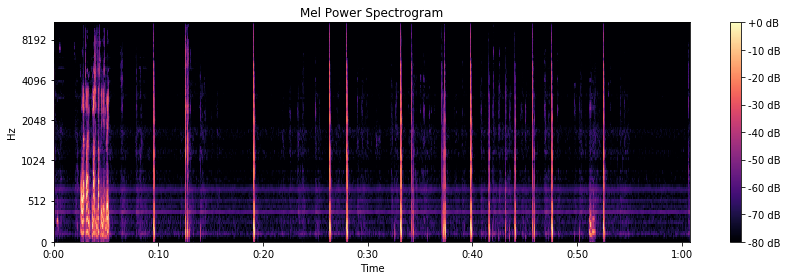

In [105]:

audio_path = 'data/common_voice/cv-valid-dev/sample-002557.mp3'
y, sr = librosa.load(audio_path)

S = librosa.feature.melspectrogram(y,sr=sr,n_mels=128)

log_S = librosa.power_to_db(S,ref=np.max)

plt.figure(figsize=(12,4))

librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectrogram')

plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

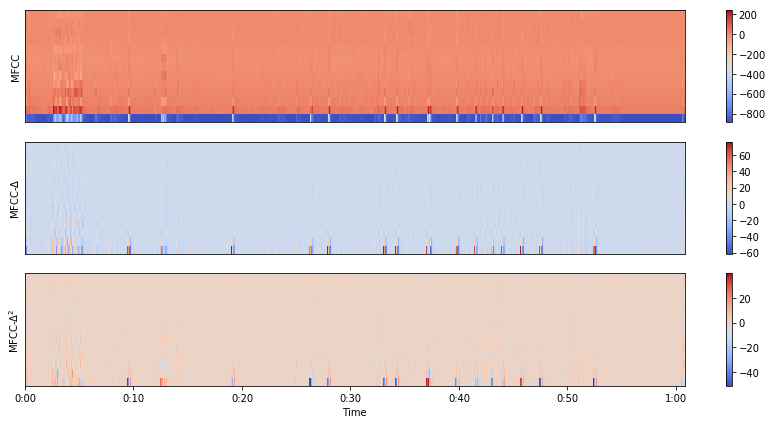

In [106]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
n_mfcc = 13
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)

#Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In [125]:
np.median(mfcc,axis=0)

array([-9.30797229, -7.71535504, -2.68970726, ..., -6.90022494,
       -2.64691047, -6.21527801])

In [113]:
yt, index = librosa.effects.trim(y, top_db=30)

In [114]:
print(librosa.get_duration(y), librosa.get_duration(yt))

(60.79201814058957, 52.68607709750567)


# Testing

## Ale's Code 

In [234]:

    

    
    
def sentence_splitter(sentences,n):
    result = []
    for sent in sentences:
        new_sents = [x.lower().strip() for x in sent.split(',')]
        for new_sent in new_sents:
            tokens = new_sent.split()
            for i in range(0, len(tokens), n):
                x = ' '.join(tokens[i:i+n])
                result.append(x)
    return result
    

def patternize_subreddit(subreddit,inc,n,max_rec=1000):
    count = 0
    thres = inc
    start_time = time.time()

    subset = first_lvl_regret[first_lvl_regret['subreddit_x']==subreddit]
    subset = subset.loc[:,['post_title','post_text']].drop_duplicates()
    total = len(subset)
    subset.index = range(len(subset.index))
    for i in range(0,total,max_rec):
        patterns_dic = {}
        new_subset = subset[i:i+max_rec]
        name = 'patterns_'+subreddit+'_' + str(int(i/max_rec)) +'.csv'
        for num,record in new_subset.iterrows():
            text = str(record['post_title'])+(str(record['post_text']) if record['post_text']==record['post_text'] else '')
            sent_text = nltk.sent_tokenize(text)
            sent_text = sentence_splitter(sent_text,n)
            for sent in sent_text:
                patterns = pattern_generator(sent)
                for pattern in patterns:
                    if not pattern in patterns_dic:
                        patterns_dic[pattern]=1
                    else:
                        patterns_dic[pattern]+=1
            count = count + 1
            if count > thres:
                thres = thres + inc
                a = count/total *100
                print("%.2f done" % a)
        x = pd.DataFrame(list(patterns_dic.items()),columns=['pattern','occurence'])
        x['subreddit']=subreddit
        x.to_csv('subreddits/patterns/'+name,encoding='utf-8')
        done = pd.read_csv('subreddits/done_patterning.csv')
        done = done.append({'subreddit':subreddit,'name':name}, ignore_index=True)
        done = done.drop_duplicates()
        done.to_csv('subreddits/done_patterning.csv',index=False,encoding='utf-8')

    print("--- %s seconds ---" % (time.time() - start_time))
    
def patterns_trimmer():
    files = pd.read_csv('subreddits/done_patterning.csv')
    for num,file in files.iterrows():
        file_name = file['name']
        print('starting ',file_name)
        original_file = pd.read_csv('subreddits/patterns/'+file_name)
        current_file = deepcopy(original_file)
        current_file = current_file.loc[:,['pattern','occurence']]
        current_file['repeated']='no'
        current_file = current_file[current_file['occurence']==1]
        print('original size',len(current_file))
        for num,file in files.iterrows():
            compared_file_name = file['name']
            if compared_file_name!=file_name:
                compared_file = pd.read_csv('subreddits/patterns/'+compared_file_name)
                current_file = current_file.merge(compared_file,on=['pattern'],how='left',indicator=True) 
                current_file = current_file[current_file['_merge'] == 'left_only']  #getting a list of those not found
                current_file = current_file.loc[:,['pattern','occurence_x']]
                current_file.columns = ['pattern','occurence']
                print('new size',len(current_file))
                
        #all patterns located in current file couldnt be found in any other file and only have 1 occurence, those should be deleted 
        current_file = original_file.merge(current_file,on=['pattern'],how='left',indicator=True)
        current_file = current_file[current_file['_merge']=='left_only']  #if found in both, is to be deleted.
        current_file = current_file.loc[:,['pattern','occurence_x']]
        current_file.columns = ['pattern','occurence']
        current_file.to_csv('subreddits/patterns/'+file_name,index=False,encoding='utf-8')  
        print('ending ',file_name)
        

In [13]:
pattern_generator('I am so happy')

['I am .+ happy',
 'am .+ happy',
 'I am so happy',
 'I .+ so happy',
 'I',
 'am so happy',
 'I am so',
 'am',
 'am so',
 'so',
 'I .+ so',
 'so happy',
 'I am',
 'I .+ .+ happy',
 'happy']

In [80]:
# checked_patterns = check_patterns(list(dev['text']),'sad')
# dev.iloc[checked_patterns['sad']]

In [79]:
# checked_patterns = check_patterns(list(train['text']),'happy')
# print(len(checked_patterns['happy']))
# train.iloc[checked_patterns['happy']]

In [78]:
# checked_patterns = check_patterns(list(train['text']),'sad')
# train.iloc[checked_patterns['sad']]

In [77]:
# checked_patterns = check_patterns(list(train['text']),'angry')
# train.iloc[checked_patterns['angry']]

In [76]:
# checked_patterns = check_patterns(list(train['text']),'fear')
# train.iloc[checked_patterns['fear']]

In [75]:
# checked_patterns = check_patterns(list(train['text']),'scared')
# train.iloc[checked_patterns['scared']]

In [120]:
# # DONT NEED THIS AT THE MOMENT
# def manually_construct_labels(emotion_sorted,emotion_name,limit):
#     result = []
#     for i in emotion_sorted.index:
#         print(emotion_sorted['text'][i])
#         answer = input("Is it "+ emotion_name + "? YES[1] NO[0]")
#         if isinstance(answer,int):
#             if int(answer) == 1:
#                 print("EMOTIONALIZE!")
#                 result.append(i)
#                 if(len(result)+1 > limit):
#                     return result
#     return result

# anger_sorted = deep_emo_dev.sort_values(by=['anger'],ascending=False).groupby(['anger']).head(1)
# result =manually_construct_labels(anger_sorted,'anger',50)